In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from astropy.io import fits

In [5]:
# data from TIC 55525572 : 1st validated planet from Planet Hunters TESS
# Data format - see:
#  https://exoplanetarchive.ipac.caltech.edu/docs/DVTimeSeries-Description.pdf
imfile = 'data/tess2019169103026-s0013-0000000055525572-0146-s_lc.fits'

hdulist = fits.open(imfile)

hdulist.info()

Filename: data/tess2019169103026-s0013-0000000055525572-0146-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20479R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   


In [6]:
hdu0 = hdulist[0]
hdu1 = hdulist[1]
hdu2 = hdulist[2]


In [7]:
print(hdu1.columns)
hdu1.header


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                20479 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [56]:
data1 = hdu1.data

# filter out incomplete data that would cause processing error
_tmp = data1[~np.isnan(data1['TIME'])]
print(f"{len(data1) - len(_tmp)} records filtered out - no TIME data")
data1 = _tmp


668 records filtered out - no TIME data


time - start: 1653.9145659271944 ; end:1682.3566529082777
SAP_FLUX median: 16293.5615234375 


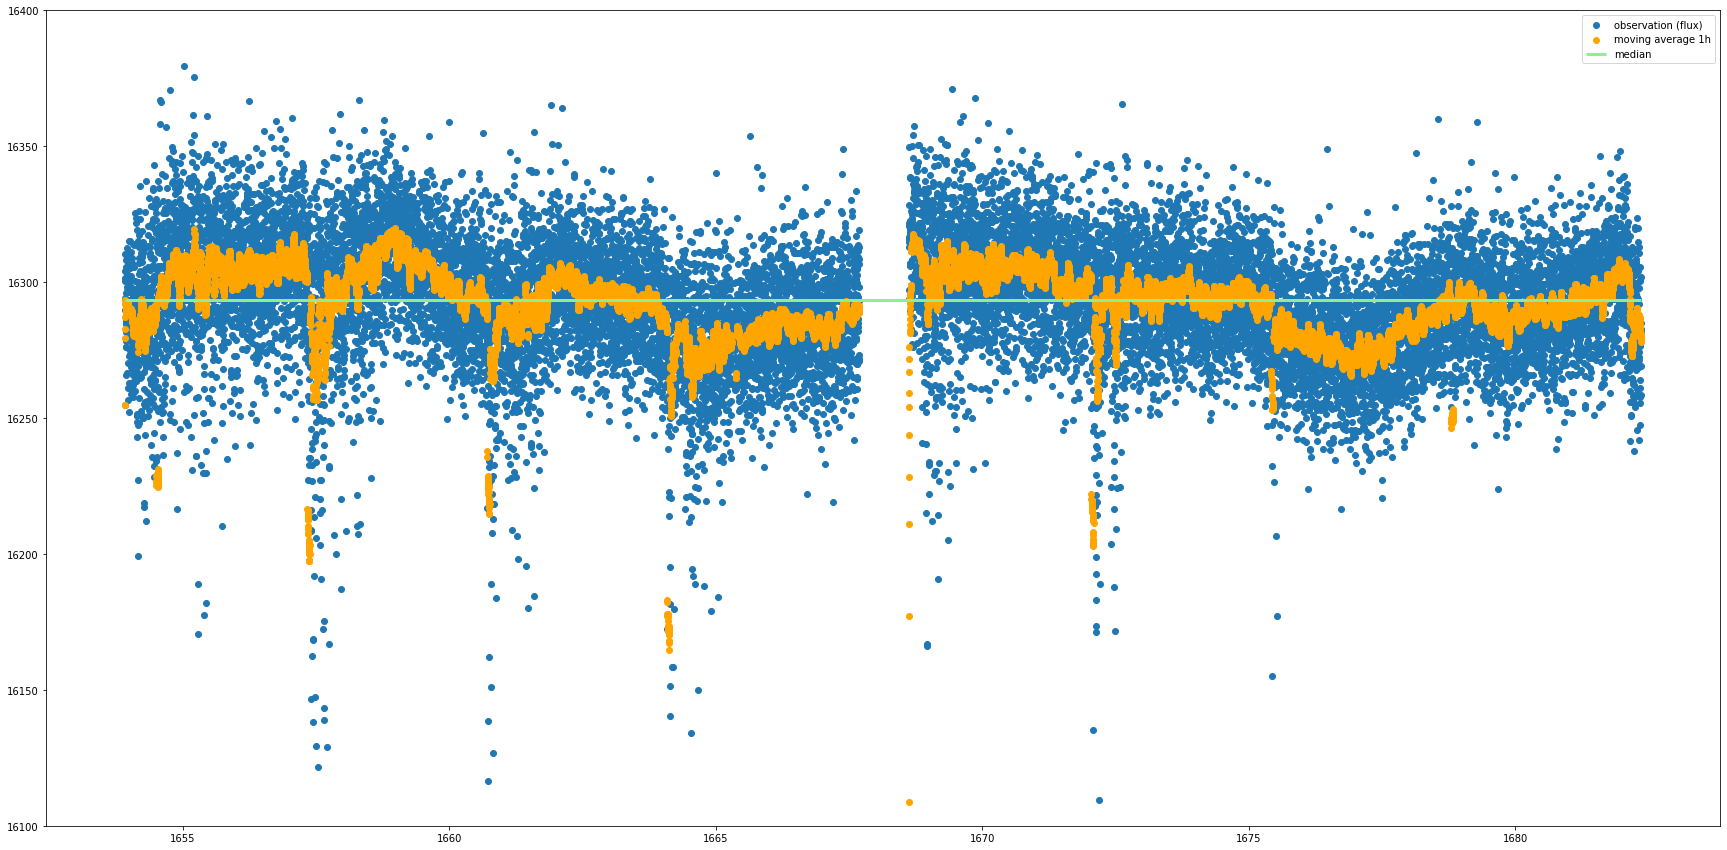

In [79]:
# # Note in the dataset, transit occurs at phase = 0
# mask_1 = data1['PHASE'] <= 1 
# mask_2 = data1['PHASE'] >= -1
# mask_3 = data1['TIME'] < 1470  # or > 1520 for next cycle, the data has cycles, so the phase is back to 0, use time to 

# subset1 = data1[np.logical_and(np.logical_and(mask_1, mask_2), mask_3)]
subset1 = data1 # no filter yet
# convert to dataframe to use panda's stats features
df1 = pd.DataFrame(subset1)


moving_avg_window = '1h'
df1['TIME_ts'] = df1['TIME'].apply(lambda x: pd.Timestamp(x * 1000000000 * 60 * 60 * 24))
df1['SAP_FLUX_MAvg'] = df1.rolling(moving_avg_window, on='TIME_ts')['SAP_FLUX'].mean()

plt.figure(figsize=(30, 15))
plt.scatter(df1['TIME'], df1['SAP_FLUX'], label='observation (flux)')
plt.scatter(df1['TIME'], df1['SAP_FLUX_MAvg'], color='orange', label=f'moving average {moving_avg_window}')
plt.hlines(df1['SAP_FLUX'].median(), df1['TIME'].min(), df1['TIME'].max(), color='lightgreen', label='median', linewidths=3)
plt.ylim(16100, 16400)
plt.legend()

print(f"time - start: {df1['TIME'].min()} ; end:{df1['TIME'].max()}")

print(f"SAP_FLUX median: {df1['SAP_FLUX'].median()} ")



True

In [70]:
# Explore aPERTURE
# print(hdu2.columns)
hdu2.header


XTENSION= 'IMAGE   '           / marks the beginning of a new HDU               
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   11 / length of first array dimension                
NAXIS2  =                   11 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'APERTURE'           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
TELESCOP= 'TESS    '           / telescope                                      
INSTRUME= 'TESS Photometer' 

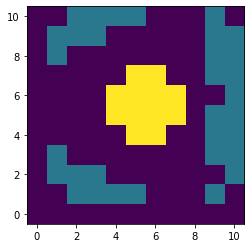

In [77]:
# Unsure about the intent of the segment
plt.imshow(data2, origin='lower')

In [8]:
# close the file
hdulist.close()

113454